# Pac-Man Gameplay with Proximal Policy Optimization and Generalized Advantage Estimation


## Part 1/2:  Implementation & Training

<h1><center>Ken K. Hong</center></h1>

# Abstract:  
This project explores gameplay using reinforcement learning in Atari 2600 Pac-Man, one of the most well-known Atari games. The project focuses on developing and evaluating reinforcement learning agents capable of mastering the game, providing insights into learning strategies and challenges within this gaming environment. Proximal Policy Optimization combined with Generalized Advantage Estimation enabled stable and efficient policy learning over 30,000 episodes and 24.6 million timesteps, achieving final evaluation rewards exceeding 500 points. Despite strong training improvements, minor reward gains during evaluation indicate challenges in policy generalization. Beyond gaming, PPO has demonstrated effectiveness in fine-tuning large language models, such as ChatGPT, via reinforcement learning from human feedback (RLHF), and it can be extended to multi-agent scenarios through algorithms like MAPPO. Future work will explore alternative algorithms, improved exploration and reward strategies, hybrid state representations, and robust evaluation methods to enhance learning efficiency and policy robustness in both single-agent and multi-agent domains.


# 1. Introduction

This project explores the application of reinforcement learning to sequential decision-making problems within the Pac-Man environment. The approach employs Proximal Policy Optimization (PPO) combined with Generalized Advantage Estimation (GAE), utilizing deep neural networks to approximate both the policy and value functions([Schulman et al., 2017](https://arxiv.org/abs/1707.06347)). The implementation is performed in the `ALE/Pacman-v5` environment from the Arcade Learning Environment([Bellemare et al., 2012](https://arxiv.org/abs/1207.4708)), where the learning agent aims to maximize the cumulative game score through strategic control.

Proximal Policy Optimization (PPO) was selected due to its empirical stability during training and its balance between implementation simplicity and performance compared to alternatives such as TRPO, TD3, and DDPG ([Schulman et al., 2017](https://arxiv.org/abs/1707.06347)). Beyond its success in game-based benchmarks, PPO has demonstrated effectiveness in diverse domains, including the alignment and fine-tuning of large language models like ChatGPT ([Ouyang et al., 2022](https://arxiv.org/abs/2203.02155),[Unsloth, 2025](https://docs.unsloth.ai/basics/reinforcement-learning-rl-guide) ), as well as continuous control tasks in environments such as Lunar Lander and AWS DeepRacer simulations ([Foundation, 2025](https://gymnasium.farama.org/environments/box2d/lunar_lander/),[Balaji et al., 2019](https://arxiv.org/abs/1911.01562) ).

Extensions of PPO have been introduced for multi-agent settings, most notably through Multi-Agent Proximal Policy Optimization (MAPPO), which has achieved strong results in cooperative environments such as the Overcooked AI challenge ([Carroll et al., 2019](https://arxiv.org/abs/1910.05789)). MAPPO addresses challenges including non-stationarity and coordination by incorporating centralized training with decentralized execution, outperforming independent PPO and Multi-Agent Deep Deterministic Policy Gradient in stability, scalability, and sample efficiency ([Yu et al., 2021](https://arxiv.org/abs/2103.01955)). Although MAPPO is beyond the scope of this study, its success highlights the adaptability of PPO to complex multi-agent environments.

The scope of this project is limited to the standard Pac-Man environment, in contrast to Ms. Pac-Man, which was tested in the original PPO evaluation. This project includes problem formulation, algorithmic design, neural network architecture, training methodology, and empirical evaluation, concluding with key observations and directions for future work.


# 2. Pac-Man Environment
The Arcade Learning Environment (ALE) provides a standardized interface for interacting with Atari 2600 games, transforming them into well-defined reinforcement learning tasks ([Bellemare et al., 2012](https://arxiv.org/abs/1207.4708)).. This project focuses on the `ALE/Pacman-v5` environment, which emulates the 1982 Atari 2600 version of the classic arcade game *Pac-Man* ([Farama Foundation, 2025](https://ale.farama.org/environments/pacman/)).

## 2.1 Environment Description
The `ALE/Pacman-v5` environment challenges the agent to navigate a maze, avoid ghosts, and collect pellets to maximize cumulative score. The game mechanics are consistent with the original design, providing a dynamic setting for sequential decision-making.

## 2.2 State Space
Atari environments offer three observation modes: RGB, grayscale, and RAM. RGB provides a $210 \times 160 \times 3$ color image, grayscale a $210 \times 160$
monochrome image, and RAM a compact 128-dimensional vector representing the console's internal memory. Traditional deep reinforcement learning approaches typically rely on raw pixel inputs processed by convolutional neural networks (CNNs). In contrast, this project leverages the ALE's internal state via the 128-byte RAM vector, which reduces the overhead of visual processing, lowers computational cost, and provides direct access to symbolic game variables. This enables a more focused evaluation of decision-making strategies. Each RAM byte (0–255) corresponds to a memory address and, unlike image inputs, lacks explicit spatial structure, requiring the agent to infer relationships purely from symbolic state data. Key memory locations encode Pac-Man's position, ghost positions, pellet states, power-up timers, score, and lives.

## 2.3 Action Space
The agent interacts with the Pac-Man environment through a discrete action space of five actions. Although the Atari 2600 controller supports 18 actions, this reduced set is sufficient for gameplay and serves as the default in the Arcade Learning Environment. The actions correspond to the four cardinal directions and a no-operation (NOOP) option, defined as:

$$
A = \{ \text{NOOP}, \text{UP}, \text{RIGHT}, \text{LEFT}, \text{DOWN} \}
$$

## 2.4 Rewards and Termination Condition
The reward structure is adapted from Pac-Man’s game scoring rules, defined as follows:

- Video wafers: +1 point.  
- Power pills: +5 points, granting temporary ability to eat ghosts.  
- Vitamins: +100 points when collected.  
- Ghosts: Points scale sequentially during a power-pill effect (20, 40, 80, 160 points).  
- Reward shaping (New): A penalty of -0.1 points per time step to encourage efficient play.

An episode terminates when all four lives are lost or the maze is cleared.

## 2.5 Challenge and Complexity
Pac-Man presents a challenging reinforcement learning environment due to its combination of sequential planning, adversarial dynamics, and uncertainty. The agent must perform real-time navigation while adapting to ghosts with distinct behavioral patterns. The game also incorporates stochasticity through sticky actions and randomized ghost movements, demanding policies that are robust to variability. These factors collectively make Pac-Man a rigorous benchmark for evaluating reinforcement learning algorithms, especially in developing strategies that balance exploration, adaptability, and efficiency under temporal constraints.


# 3. Proximal Policy Optimization with GAE

Clipped Proximal Policy Optimization (PPO) combined with Generalized Advantage Estimation (GAE) offers a robust and efficient approach to policy learning. The clipped surrogate objective, together with GAE, prevents large policy updates that could destabilize training, resulting in more reliable performance and easier hyperparameter tuning.

## 3.1 Actor-Critic Architecture

PPO utilizes an actor-critic framework composed of two neural networks trained concurrently:

- **Actor (Policy Network,** $\pi_\theta$**):** This network models the policy by mapping the current state $s_t$ to action probabilities. It consists of a four-layer multilayer perceptron (MLP) with ReLU activations implemented in PyTorch. The output layer produces raw action logits without activation, facilitating integration with categorical distributions.  
- **Critic (Value Network,** $V_\phi$**):** This network estimates the state value $V_\phi(s_t)$, representing expected cumulative future reward from state $s_t$. The critic shares the same architecture as the actor, including orthogonal weight initialization, and outputs a single scalar without nonlinear activation.

## 3.2 Network Architecture for RAM-Based Inputs

Given the 128-dimensional Atari RAM state as input, a multilayer perceptron (MLP) architecture was employed for both actor and critic, as discussed above. This approach contrasts with pixel-based methods that typically use convolutional neural networks to capture spatial features.

Each network consists of four fully connected layers with 256 hidden units per layer and ReLU activations. Layer Normalization is applied after each hidden layer to improve training stability by reducing internal covariate shift. The actor network outputs logits corresponding to the five discrete actions available in the environment, while the critic outputs a scalar value estimate.

## 3.3 Clipped Surrogate Objective

The core innovation in PPO is the clipped surrogate objective, which limits policy updates by constraining the probability ratio between new and old policies, thereby enhancing training stability and efficiency:

$$
r_t(\theta) = \frac{\pi_{\theta}(a_t \mid s_t)}{\pi_{\theta_\text{old}}(a_t \mid s_t)}
$$

The objective function is defined as:

$$
L_\text{CLIP}(\theta) = \hat{\mathbb{E}}_t \left[ \min \left( r_t(\theta) \hat{A}_t, \, \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon) \hat{A}_t \right) \right]
$$

Here, $\hat{A}_t$ denotes the estimated advantage and $\epsilon$ defines the clipping threshold. This mechanism restricts excessively large policy updates while avoiding the complexity of trust region methods such as TRPO. The pseudocode for PPO implementation is illustrated in Figure 1.


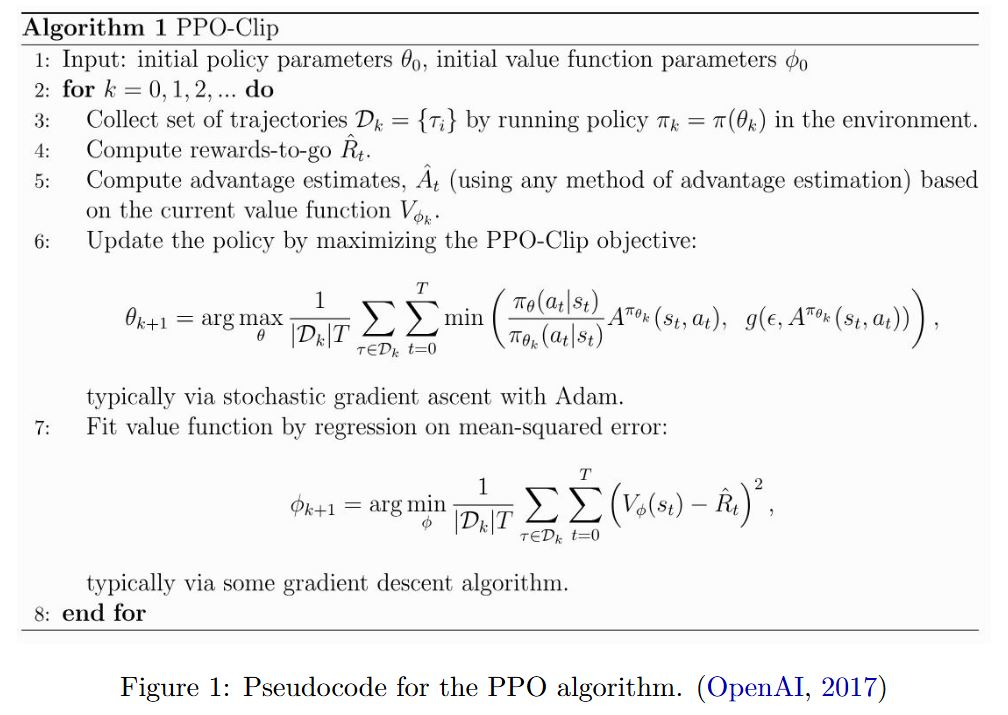

In [ ]:
from IPython.display import display, Image
display(Image("/content/Figure1.jpg", width=600, height=400))

## 3.4 Generalized Advantage Estimation

The effectiveness of policy updates depends on the accuracy of the advantage estimate, defined as $\hat{A}_t = Q(s_t, a_t) - V(s_t)$. GAE enhances this by balancing bias and variance.  ([Schulman et al., 2015](https://arxiv.org/abs/1506.02438))

The one-step temporal difference error is defined as:

$$
\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t),
$$

which has low variance but potential bias due to dependence on value estimates. Monte Carlo returns provide unbiased estimates but suffer from high variance.

GAE computes an exponentially weighted sum of temporal difference errors:

$$
\hat{A}^{\text{GAE}}_t(\gamma, \lambda) = (1 - \lambda)\left( \delta_t^V + \lambda \delta_{t+1}^V + \lambda^2 \delta_{t+2}^V + \cdots \right) = \sum_{l=0}^{\infty} (\gamma \lambda)^l \delta_{t+l}
$$

where $\lambda$ controls the bias-variance trade-off. Values close to 0.95 have shown empirical effectiveness. This approach yields smoother, more informative advantage signals, complementing PPO's clipped updates for improved learning stability.

## 3.5 Rollout Buffer

The RolloutBuffer collects and stores experience tuples during training, including states, actions, action log probabilities, rewards, done flags, and value estimates at each time step. Accumulated data over rollouts enables multiple minibatch epochs per update, enhancing sample efficiency and stabilizing policy optimization. ([Emma Brunskill et al., 2025](https://web.stanford.edu/class/cs234/), [OpenAI, 2017](https://spinningup.openai.com/en/latest/algorithms/ppo.html)).

## 3.6 Training Configuration and Gradient Stabilization

Training the PPO agent requires careful optimization and gradient control to maintain stability and efficiency. This section outlines the optimization setup, including the optimizer choice, parameter initialization, and gradient clipping, based on the approach in ([Engstrom et al., 2020](https://arxiv.org/abs/2005.12729))

**Optimizer**  

Adam optimizer was employed to update both actor and critic networks. Learning rates were determined through empirical tuning and remained constant, resulting in stable and consistent training. Future work may explore cosine decay to gradually reduce the learning rate.


**Gradient Clipping**  

To prevent unstable updates and exploding gradients, gradients were clipped to keep the global norm below 0.5, ensuring stable training and preventing divergence.

**Orthogonal Initialization**  

Weights were initialized orthogonally to preserve gradient scales during backpropagation, promoting better convergence and more stable training.

In [ ]:
# !pip install "gymnasium[atari]"
# !pip install ale-py

In [ ]:
import time
from collections import deque

import ale_py
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from tqdm.notebook import tqdm

In [ ]:
class PolicyNet(nn.Module):
    """The policy network (Actor) for selecting actions."""
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(PolicyNet, self).__init__()
        # 4-layer MLP with dropout and ReLU non-linearities added
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
        self._init_weights()

    def _init_weights(self):
        """Initializes network weights orthogonally.  - https://arxiv.org/abs/2005.12729"""
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.orthogonal_(layer.weight, gain=1.0)
                nn.init.constant_(layer.bias, 0)

    def forward(self, state):
        return self.network(state)

class ValueNet(nn.Module):
    """The value network (Critic) for estimating state value."""
    def __init__(self, state_dim, hidden_dim=256):
        super(ValueNet, self).__init__()
        # 4-layer MLP with dropout and ReLU non-linearities added
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self._init_weights()

    def _init_weights(self):
        """Initializes network weights orthogonally.  - https://arxiv.org/abs/2005.12729"""
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.orthogonal_(layer.weight, gain=1.0)
                nn.init.constant_(layer.bias, 0)

    def forward(self, state):
        return self.network(state)

In [ ]:
# Memory Buffer:  temporarily stores on-policy experiences to enable efficient batch updates,
# Goal: reducing gradient variance and managing the bias-variance trade-off in advantage estimation.

class RolloutBuffer:
    """Stores transitions collected by the agent."""
    def __init__(self):
        self.states, self.actions, self.log_probs = [], [], []
        self.rewards, self.dones, self.values = [], [], []

    def store(self, state, action, log_prob, reward, done, value):
        self.states.append(state)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.rewards.append(reward)
        self.dones.append(done)
        self.values.append(value)

    def clear(self):
        self.states.clear(); self.actions.clear(); self.log_probs.clear()
        self.rewards.clear(); self.dones.clear(); self.values.clear()

In [ ]:
class PPOAgent:
    """The PPO Agent with standard stochastic exploration."""
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma,
                 K_epochs, eps_clip, gae_lambda, hidden_dim=256):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.gae_lambda = gae_lambda

        self.actor = PolicyNet(state_dim, action_dim, hidden_dim).to(self.device)
        self.critic = ValueNet(state_dim, hidden_dim).to(self.device)
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.mse_loss = nn.MSELoss()

    def select_action(self, state):
        """Selects a stochastic action based on the current policy."""
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state / 255.0).to(self.device)
            logits = self.actor(state_tensor)
            dist = Categorical(logits=logits)
            action = dist.sample()
            log_prob = dist.log_prob(action)
            value = self.critic(state_tensor)
        return action.item(), log_prob.item(), value.item()

    def update(self, memory):
        """Updates the actor and critic networks."""
        states = torch.from_numpy(np.array(memory.states, dtype=np.float32)).to(self.device)
        actions = torch.tensor(memory.actions, dtype=torch.int64).to(self.device)
        old_log_probs = torch.tensor(memory.log_probs, dtype=torch.float32).to(self.device)
        rewards = torch.tensor(memory.rewards, dtype=torch.float32).to(self.device)
        dones = torch.tensor(memory.dones, dtype=torch.float32).to(self.device)
        values = torch.tensor(memory.values, dtype=torch.float32).to(self.device)

        states /= 255.0

        advantages = torch.zeros_like(rewards).to(self.device)
        last_gae = 0

        # GAE Paper: https://arxiv.org/pdf/1506.02438
        for t in reversed(range(len(rewards))):
            mask = 1.0 - dones[t]
            next_value = values[t+1] if t < len(rewards)-1 else 0
            delta = rewards[t] + self.gamma * next_value * mask - values[t]
            last_gae = delta + self.gamma * self.gae_lambda * mask * last_gae
            advantages[t] = last_gae
        returns = advantages + values

        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-7)

        # PPO Optimization: https://spinningup.openai.com/en/latest/algorithms/ppo.html
        for _ in range(self.K_epochs):
            logits = self.actor(states)
            dist = Categorical(logits=logits)
            new_log_probs = dist.log_prob(actions)
            entropy = dist.entropy().mean()

            ratios = torch.exp(new_log_probs - old_log_probs)
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss_actor = -torch.min(surr1, surr2).mean() - 0.01 * entropy

            value_est = self.critic(states).squeeze()
            loss_critic = self.mse_loss(value_est, returns)

            self.optimizer_actor.zero_grad()
            loss_actor.backward()

            # Clip gradients to prevent exploding gradients - https://arxiv.org/abs/2005.12729
            nn.utils.clip_grad_norm_(self.actor.parameters(), 0.5)
            self.optimizer_actor.step()

            self.optimizer_critic.zero_grad()
            loss_critic.backward()
            nn.utils.clip_grad_norm_(self.critic.parameters(), 0.5)
            self.optimizer_critic.step()

    def save(self, filepath):
        """Saves model weights."""
        torch.save({
            'actor_state_dict': self.actor.state_dict(),
            'critic_state_dict': self.critic.state_dict(),
        }, filepath)
        print(f"Saved model to {filepath}")

    def load(self, filepath):
        """Loads the saved model weights for retraining."""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.actor.load_state_dict(checkpoint['actor_state_dict'])
        self.critic.load_state_dict(checkpoint['critic_state_dict'])
        print(f"Loaded model from {filepath}")

In [ ]:
def train_agent(env, hyperparams, filepath='pacman_model', resume_from=None, start_episode=1):
    """Main training loop with detailed logging and interactive checkpointing."""
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent_params = {
        'state_dim': state_dim, 'action_dim': action_dim,
        'lr_actor': hyperparams['lr_actor'],
        'lr_critic': hyperparams['lr_critic'],
        'gamma': hyperparams['gamma'],
        'K_epochs': hyperparams['K_epochs'],
        'eps_clip': hyperparams['eps_clip'],
        'gae_lambda': hyperparams['gae_lambda'],
        'hidden_dim': hyperparams['hidden_dim']
    }
    agent = PPOAgent(**agent_params)

    if resume_from:
        agent.load(resume_from)

    memory = RolloutBuffer()

    # Automatic sliding window that keeps the most recent 100 items.
    rewards_log, std_log, recent_scores = [], {}, deque(maxlen=100)
    timestep = 0
    start_time = time.time()
    last_checkpoint_time = start_time

    episode = 1
    total_episodes = hyperparams['checkpoint_interval']
    checkpoint_interval = hyperparams['checkpoint_interval']

    if start_episode > 1:
        try:
            rewards_log = pd.read_csv(f"{filepath}_reward_ep{start_episode}.csv")['reward'].tolist()
            std_log = pd.read_csv(f"{filepath}_std_ep{start_episode}.csv", index_col=0).to_dict()['std']
            print(f"Resumed logs. Starting from episode {start_episode}.")
        except FileNotFoundError:
            print("Could not find previous log files. Starting with fresh logs.")
            rewards_log, std_log = [], {}
    else:
        rewards_log, std_log = [], {}

    print(f"\n{filepath} \ntraining with params:\n{hyperparams}")
    episode = start_episode + 1
    total_episodes = start_episode + hyperparams['checkpoint_interval']
    checkpoint_interval = hyperparams['checkpoint_interval']

    with tqdm(total=total_episodes, desc="Training Episodes") as pbar:
        while episode <= total_episodes:

            # Learning Rate Annealing
            frac = 1.0 - (episode - 1.0) / total_episodes
            lr_now = frac * hyperparams['lr_actor']
            agent.optimizer_actor.param_groups[0]["lr"] = lr_now
            agent.optimizer_critic.param_groups[0]["lr"] = frac * hyperparams['lr_critic']

            state, _ = env.reset()
            ep_reward = 0
            for t in range(hyperparams['max_timesteps']):
                timestep += 1
                action, logp, value = agent.select_action(state)
                next_state, reward, term, trunc, _ = env.step(action)
                reward -= 0.1 # Reward Shaping  - Apply a small penalty for each timestep to encourage efficiency
                done = term or trunc
                memory.store(state, action, logp, reward, done, value)
                state = next_state
                ep_reward += reward

                if timestep % hyperparams['update_timestep'] == 0:
                    agent.update(memory)
                    memory.clear()
                if done:
                    break

            rewards_log.append(ep_reward)
            recent_scores.append(ep_reward)
            std_log[episode] = np.std(recent_scores)

            if episode % 100 == 0:
                avg = np.mean(recent_scores)
                std = np.std(recent_scores)
                pbar.set_description(f"Ep {episode} | Avg R: {avg:.2f}")
                print(f"\nEpisode {episode}: Avg reward over last {len(recent_scores)} episodes = {avg:.2f} \
                                                                  | Standard deviation: {std:.2f}")

            if episode % checkpoint_interval == 0 and episode > 0:
                print("\n" + "-"*50 + f" CHECKPOINT at episode {episode} " + "-"*50)
                agent.save(f"{filepath}_ep{episode}.pth")

                df_reward = pd.DataFrame(rewards_log, columns=['reward'])
                df_reward.to_csv(f"{filepath}_reward_ep{episode}.csv", index=True)
                print(f"Saved reward log to {filepath}_reward_ep{episode}.csv")

                df_std = pd.DataFrame.from_dict(std_log, orient='index', columns=['std'])
                df_std.to_csv(f"{filepath}_std_ep{episode}.csv", index=True)
                print(f"Saved std log to {filepath}_std_ep{episode}.csv")


                elapsed = time.time() - last_checkpoint_time
                last_checkpoint_time = time.time()
                cp_minutes, cp_seconds = divmod(elapsed, 60)
                print(f"\nTotal training time: {int(cp_minutes)} minutes {int(cp_seconds)} seconds \
                                                              | Total timesteps so far: {timestep:,}")

                response = input(f"Continue training for another {checkpoint_interval} \
                                                              episodes? (y/n): ").lower()
                if response in ['y', 'yes']:
                    total_episodes += checkpoint_interval
                    pbar.total = total_episodes
                    print(f"Training extended. New target: {total_episodes} episodes.")
                    print("-" * (130 + len(str(episode))) + "\n")

                else:
                    print("Stopping training.")
                    print("-" * (130 + len(str(episode))) + "\n")

                    agent.save(filepath + "_final.pth")

                    total_time = time.time() - start_time
                    minutes, seconds = divmod(total_time, 60)
                    print("\n" + "-" * 130)
                    print(f"Training stopped at episode {episode} | Total timesteps: {timestep:,}")
                    print(f"Average reward over last 100 episodes: {np.mean(recent_scores):.2f}")
                    print(f"Total training time: {int(minutes)} minutes {int(seconds)} seconds")

                    return rewards_log, agent, std_log

            if len(recent_scores) == 100 and np.mean(recent_scores) >=800:
                total_time = time.time() - start_time
                minutes, seconds = divmod(total_time, 60)
                print("\n" + "-" * 130)

                print(f"Environment solved in {episode} episodes | Total timesteps: {timestep:,}")
                print(f"Average reward over last 100 episodes: {np.mean(recent_scores):.2f}")
                print(f"Total training time: {int(minutes)} minutes {int(seconds)} seconds")
                return rewards_log, agent, std_log

            pbar.update(1)
            episode += 1

    agent.save(filepath + "_final.pth")
    return rewards_log, agent, std_log

In [ ]:
def plot_results(key, results_dict, params):
    """Plots the results of experiment."""
    rewards_list = results_dict['rewards'][0]
    moving_avg = [np.mean(rewards_list[j:j+100]) for j in range(len(rewards_list) - 99)] \
                                             if len(rewards_list) >= 100 else []

    plt.figure(figsize=(12, 7))
    plt.plot(rewards_list, alpha=0.3, label='Episode Reward')
    if moving_avg:
        plt.plot(range(99, len(rewards_list)), moving_avg, color='r', linestyle='-',
                                            lw=2, label='100-Episode Moving Average')

    plt.title(f"Training: {key} | Random Seed: 42", fontsize=18, fontweight='bold', pad=15)
    plt.xlabel("Episode", fontsize=18)
    plt.ylabel("Reward", fontsize=18)
    plt.ylim(-100, 1000)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend()
    plt.legend(fontsize=14, loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{key}_training_plot.png")
    print(f"Saved plot to {key}_training_plot.png")
    plt.show()

def set_seed(seed, env=None):
    """Sets random seeds for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    if env is not None:
        env.reset(seed=seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)

# 4. Training Configuration

This section details the training configuration. Hyperparameters were selected following established best practices from prior work, including PPO implementations on the Lunar Lander environment and MAPPO applied to the Overcooked AI task ([Foundation, 2025](https://gymnasium.farama.org/environments/box2d/lunar_lander/),[Carroll et al., 2019](https://arxiv.org/abs/1910.05789) ), ensuring consistency and comparability in performance evaluation.

## 4.1 Hyperparameter Overview

The performance of the PPO agent in the `ALE/Pacman-v5` environment is highly sensitive to the tuning of key hyperparameters. These parameters critically influence training dynamics, including the stability of policy updates, the balance between exploration and exploitation, and overall sample efficiency. The values presented in Table 1 were selected based on established literature and prior practical experience, then further refined through empirical evaluation. This configuration facilitates stable convergence of the actor-critic architecture while ensuring robustness throughout training.

## 4.2 Hyperparameter Configuration
Table 1 summarizes the key hyperparameters used during training, including learning rates, discount factors, PPO clipping thresholds, network architecture parameters, and scheduling intervals for checkpointing and result saving.

<table style="width: 80%; margin-left: auto; margin-right: auto; border-collapse: collapse; font-family: Arial, sans-serif;">
<thead>
<tr>
<th style="border: 1px solid #ddd; padding: 8px; text-align: left; width: 20%;">Hyperparameter</th>
<th style="border: 1px solid #ddd; padding: 8px; text-align: center; width: 15%;">Symbol</th>
<th style="border: 1px solid #ddd; padding: 8px; text-align: left; width: 45%;">Description</th>
<th style="border: 1px solid #ddd; padding: 8px; text-align: center; width: 20%;">Value</th>
</tr>
</thead>
<tbody>
<tr>
<td style="border: 1px solid #ddd; padding: 8px;">lr_actor</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: center;">$\alpha_{\text{actor}}$</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: left !important;">Learning rate for the actor network</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: center;">$2.5 \times 10^{-4}$</td>
</tr>
<tr>
<td style="border: 1px solid #ddd; padding: 8px;">lr_critic</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: center;">$\alpha_{\text{critic}}$</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: left !important;">Learning rate for the critic network</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: center;">$5 \times 10^{-4}$</td>
</tr>
<tr>
<td style="border: 1px solid #ddd; padding: 8px;">gamma</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: center;">$\gamma$</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: left !important;">Discount factor</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: center;">0.99</td>
</tr>
<tr>
<td style="border: 1px solid #ddd; padding: 8px;">K_epochs</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: center;">$K$</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: left !important;">Number of epochs per update</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: center;">10</td>
</tr>
<tr>
<td style="border: 1px solid #ddd; padding: 8px;">eps_clip</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: center;">$\epsilon$</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: left !important;">Clipping parameter for update size</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: center;">0.2</td>
</tr>
<tr>
<td style="border: 1px solid #ddd; padding: 8px;">gae_lambda</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: center;">$\lambda$</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: left !important;">GAE lambda parameter</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: center;">0.96</td>
</tr>
<tr>
<td style="border: 1px solid #ddd; padding: 8px;">hidden_dim</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: center;">$h$</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: left !important;">Number of units in hidden layers</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: center;">256</td>
</tr>
<tr>
<td style="border: 1px solid #ddd; padding: 8px;">max_timesteps</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: center;">$T_{\text{max}}$</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: left !important;">Maximum timesteps per episode</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: center;">20,000</td>
</tr>
<tr>
<td style="border: 1px solid #ddd; padding: 8px;">update_timestep</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: center;">$T_{\text{update}}$</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: left !important;">Timesteps before each policy update</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: center;">8,192</td>
</tr>
<tr>
<td style="border: 1px solid #ddd; padding: 8px;">checkpoint_interval</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: center;">-</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: left !important;">Episodes between model checkpoint saves</td>
<td style="border: 1px solid #ddd; padding: 8px; text-align: center;">5,000</td>
</tr>
</tbody>
</table>


In [ ]:
gym.register_envs(ale_py)
env = gym.make('ALE/Pacman-v5', obs_type='ram')
seed = 42
set_seed(seed, env)

base_params = {
    'lr_actor': 2.5e-4,
    'lr_critic': 5e-4,
    'gamma': 0.99,
    'K_epochs': 10,
    'eps_clip': 0.2,
    'gae_lambda': 0.96,
    'hidden_dim': 256,
    'max_timesteps': 20000,  #  ~5.5 minutes of real-time gameplay
    'update_timestep': 8192,
    'checkpoint_interval': 5000
}

hyperparam_sets = {
    "pacman_ppo_model": {},
    # "trial1_gae_lambda_0.8": {  # GAE lambda reduced to 0.8  - Low gae_lambda for lower variance but higher bias
    #     'gae_lambda': 0.8}, # Orig 0.95

    # "trial2_ppo_clip_0.4": {  # PPO clipping parameter increased to 0.4 (less strict clipping)
    #     'eps_clip': 0.4},  # Orig 0.2

    # "trial3_network_hidden_128": {  # Hidden layer size reduced to 128 units (smaller network capacity)
    #     'hidden_dim': 128}, # Orig 256
}

In [ ]:
experiment_results = {}
for name, params_update in hyperparam_sets.items():
    current_params = base_params.copy()
    current_params.update(params_update)

    current_params['num_episodes'] = current_params['checkpoint_interval']
    rewards_history, agent, std_log = train_agent(env, current_params, filepath=name,
                                                  resume_from="pacman_ppo_model_ep20000.pth", start_episode=20000)
                                                  # Use None if not resuming training from a checkpoint.

    df_reward = pd.DataFrame(rewards_history, columns=['reward'])
    df_reward.to_csv(f"{name}_reward_final.csv", index=True)
    print(f"Saved reward to {name}_reward_final.csv")

    df_std = pd.DataFrame.from_dict(std_log, orient='index', columns=['std'])
    df_std.to_csv(f"{name}_std_final.csv", index=True)
    print(f"Saved std log to {name}_std_final.csv")

    experiment_results[name] = {'rewards': [rewards_history, agent], 'params': current_params}

    print("\n" + "="*80 + "\n")

Loaded model from pacman_ppo_model_ep20000.pth
Resumed logs. Starting from episode 20000.

pacman_ppo_model 
training with params:
{'lr_actor': 0.00025, 'lr_critic': 0.0005, 'gamma': 0.99, 'K_epochs': 10, 'eps_clip': 0.2, 'hidden_dim': 256, 'gae_lambda': 0.96, 'max_timesteps': 20000, 'update_timestep': 8192, 'checkpoint_interval': 5000, 'num_episodes': 5000}


Training Episodes:   0%|          | 0/25000 [00:00<?, ?it/s]


Episode 20100: Avg reward over last 100 episodes = 370.18 | Standard deviation: 108.05

Episode 20200: Avg reward over last 100 episodes = 347.38 | Standard deviation: 93.94

Episode 20300: Avg reward over last 100 episodes = 350.63 | Standard deviation: 107.30

Episode 20400: Avg reward over last 100 episodes = 364.38 | Standard deviation: 122.61

Episode 20500: Avg reward over last 100 episodes = 320.58 | Standard deviation: 253.21

Episode 20600: Avg reward over last 100 episodes = 361.10 | Standard deviation: 122.29

Episode 20700: Avg reward over last 100 episodes = 348.80 | Standard deviation: 113.89

Episode 20800: Avg reward over last 100 episodes = 372.97 | Standard deviation: 109.68

Episode 20900: Avg reward over last 100 episodes = 358.00 | Standard deviation: 117.16

Episode 21000: Avg reward over last 100 episodes = 365.93 | Standard deviation: 108.81

Episode 21100: Avg reward over last 100 episodes = 361.33 | Standard deviation: 98.50

Episode 21200: Avg reward over la

Saved plot to pacman_ppo_model_training_plot.png


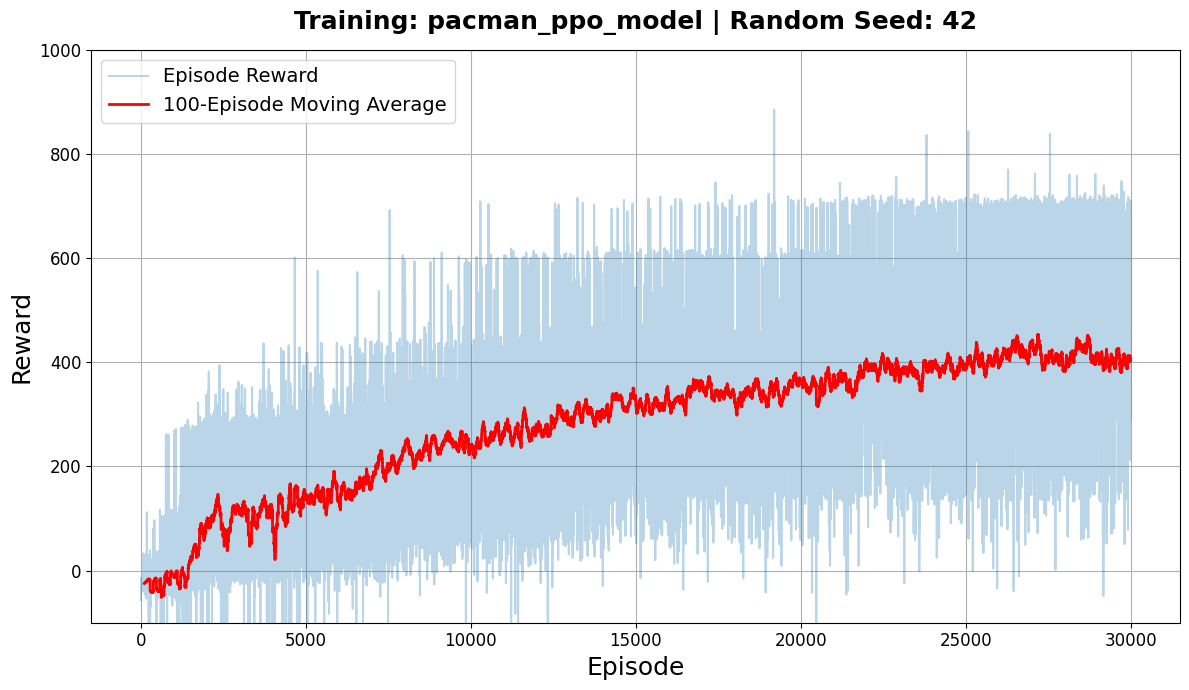

In [ ]:
plot_results(name, experiment_results[name], current_params)